Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Pasit Tiwawongrut"
ID = "122442"

---

# Lab 10: Convolutional Neural Networks

Today we'll experiment with CNNs. We'll start with a hand-coded CNN structure based on numpy, then we'll move to PyTorch.

## Hand-coded CNN

This example is based on [Ahmed Gad's tutorial](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html).

We will implement a very simple CNN in numpy. The model will have
just three layers, a convolutional layer (conv for short), a ReLU activation layer, and max pooling. The major steps involved are as follows.
1. Reading input images.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking the conv, ReLU, and max pooling layers.

### Reading an input image
 
The following code reads an existing image using the SciKit-Image Python library and converts it into grayscale. You may need to `pip install scikit-image`.

Image dimensions: (300, 451, 3)


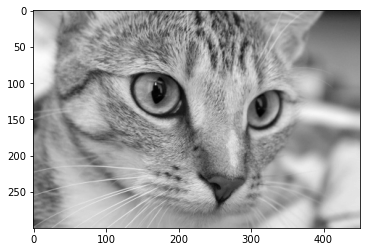

In [2]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image
img = skimage.data.chelsea()
print('Image dimensions:', img.shape)

# Convert to grayscale
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()

### Create some filters for the conv layer

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching
the number of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one
feature map (channel) in the result.

In this case, the convolution (cross correlation) computation can be written
$$\mathtt{X}'(i, j, k) = (\mathtt{X} \star \mathtt{K}_k)(i, j) = \sum_m \sum_n \sum_c \mathtt{X}(i+m, j+n, c)
\mathtt{K}_k(m, n, c),$$
where $\mathtt{X}$ is an input tensor with three dimensions ($H$ rows, $W$ columns, and $C$ channels),
$\mathtt{K}_k$ is likewise an input tensor with three dimensions ($M$ rows, $N$ columns, and $C$ channels),
resulting in feature map $\mathtt{X}'(\cdot, \cdot, k)$, i.e., the $k$th channel of the overall output tensor.
If our conv layer contains $K$ kernels $\mathtt{K}_1, \ldots, \mathtt{K}_K$, after $K$ of these convolution
operations, the resulting tensor $\mathtt{X}'$ will contain $K$ channels.

Let's make two $3\times3\times1$ filters, using the horizontal and vertical Sobel edge filters, flipped horizontally
and vertically so that they give positive values for increasing intensity across an edge when used in cross
correlation rather than convolution mode:

In [3]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])

### Conv layer feedforward step
 
Let's convolve (correlate) an input image with our filters. The convolution will be stride
1 and valid region only.

In [4]:
# Convolution (cross correlation operation) with stride 1 for a single channel kernel,
# assuming the input image is also single channel.

def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1]
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)
            result[r, c] = conv_sum
    
    return result       

# Perform convolution with a set of filters and return the result

def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]

        if len(curr_filter.shape) > 2:
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

Let's give it a try:

2.01 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Convolutional feature maps shape: (298, 449, 2)


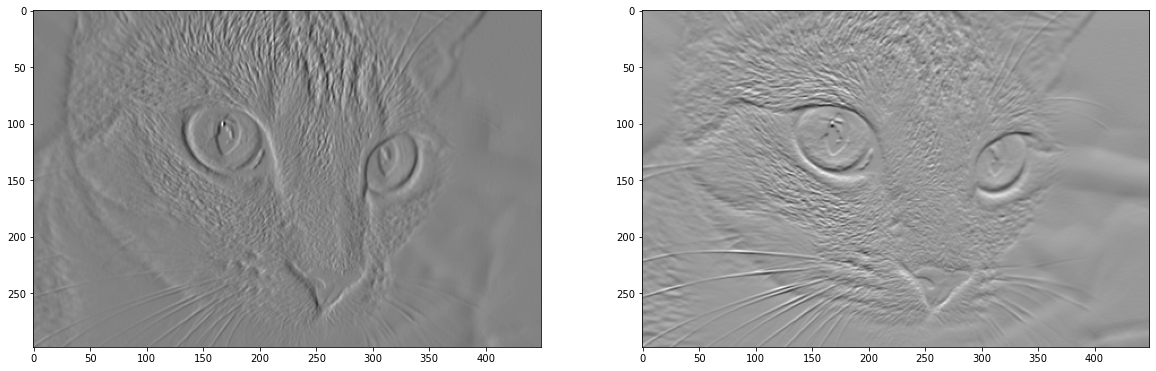

In [5]:
features = conv(img, l1_filters)
%timeit conv(img,l1_filters)

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

Cool, right? A couple observations:
1. We've hard coded the values in the filters, so they are sensible to us. In a real CNN, we'd be tuning the filters to minimize loss on the training set, so we wouldn't expect such perfectly structured results.
2. Naive implementation of 2D convolutions requires 4 nested loops, which is super slow in Python. In the code above, we've replaced the two inner loops with an element-by-element matrix multiplication for the kernel and the portion of the image applicable for the current indices into the convoution result.

### Exercise (15 points)

The semi-naive implementation of the convolution function above could be sped up with the use of a fast low-level 2D convolution routine that makes the best possible use of the CPU's optimized instructions, pipelining of operations, etc. Take a look at [Laurent Perrinet's blog on 2D convolution implementations](https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html) and see how the two fastest implementations,
scikit and numpy, outperform other methods and should vastly outperform the Python loop above. Reimplement the <code>convolve()</code> function above to be <code>convole2()</code> and compare
the times taken by the naive and optimized versions of your convolution operation for the cat image. In your report, briefly describe the experiment and the
results you obtained.

- Implement an optimized CNN convolution operation (10 points)
- Describe the experiment and the results (5 points)

<details>
    <summary><font size="3" color="green"><b>Get a hint!</b></font></summary>
    
Use <code>numpy.fft</code>'s `fft2` and `ifft2` functions.

</details>

In [6]:
from numpy.fft import fft2, ifft2

def convolve2(img, conv_filter):
    output = np.real(ifft2(fft2(img)*fft2(conv_filter, s=img.shape)))
    return output

def conv2(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    feature_maps = np.zeros((img.shape[0], 
                             img.shape[1], 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]

        if len(curr_filter.shape) > 2:
            conv_map = convolve2(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve2(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve2(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

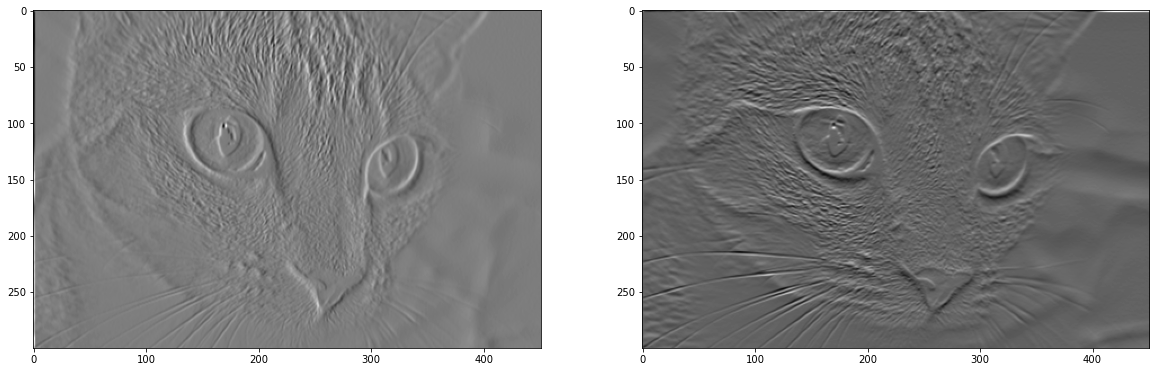

In [7]:
convolv_img = conv2(img, l1_filters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convolv_img[:,:,0], cmap='gray')
ax2.imshow(convolv_img[:,:,1], cmap='gray')
plt.show()

19.1 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Convolutional feature maps shape: (300, 451, 2)


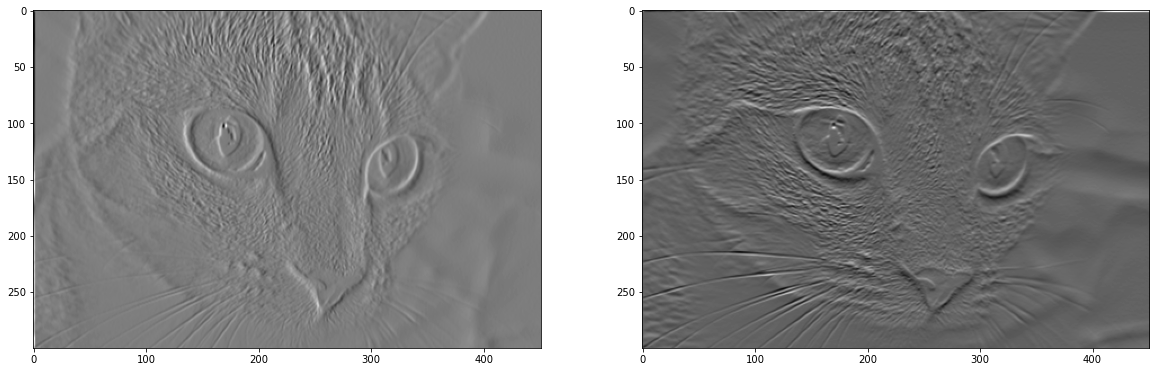

success!


In [8]:
import datetime
start = datetime.datetime.now()
features = conv2(img, l1_filters)
stop = datetime.datetime.now()
%timeit conv2(img,l1_filters)

c = stop - start
elapsed = c.microseconds / 1000 # millisec

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

# Test function: Do not remove
assert elapsed < 200, "Convolution is too slow, try again"
print("success!")
# End Test function

In this test, we use fourrier transform to calculate the convolution image instead of for loop. Fourrier transform change operation into multiply instead of convolution. So this make calculation a lot more faster. The shape of result do not shrink.

### Pooling and relu

Next, we consider the feedforward pooling and ReLU operations.

In [9]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

Now let's try the ReLU and pooling operations on the result of the previous convolutions:

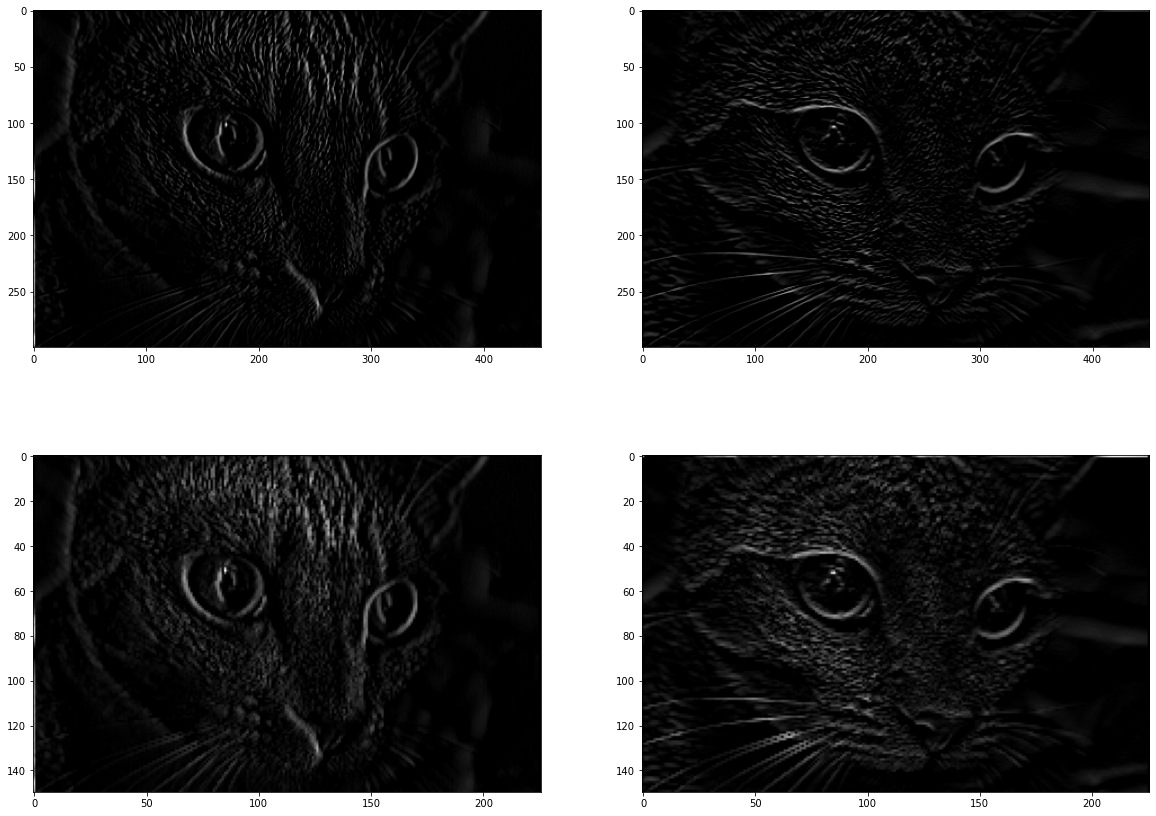

In [10]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
plt.show()


Next, let's visualize all of the feature maps in the model together.

In [11]:
# First conv layer

import sys

np.set_printoptions(threshold=sys.maxsize)

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)


conv layer 1...
conv layer 2...
conv layer 3...


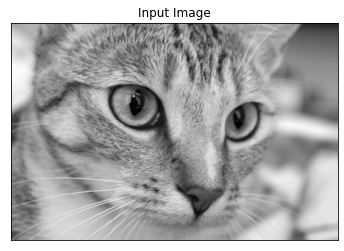

In [12]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


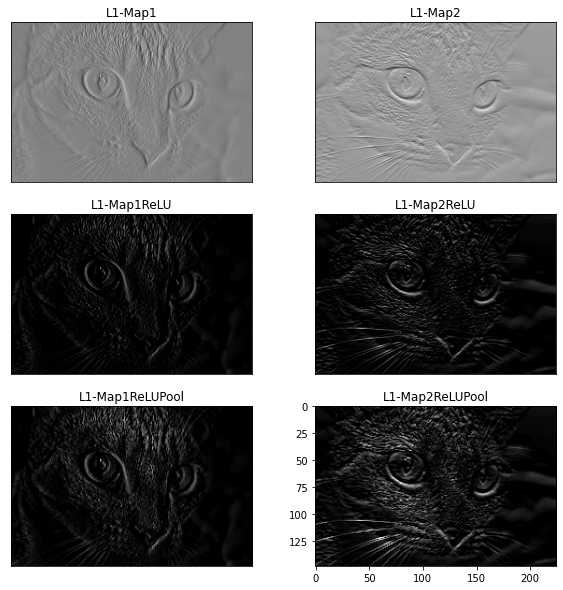

In [13]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


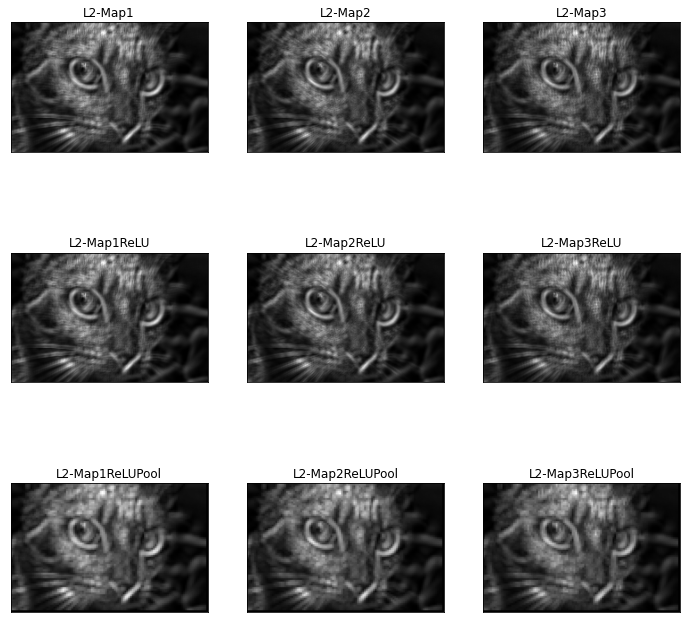

In [14]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

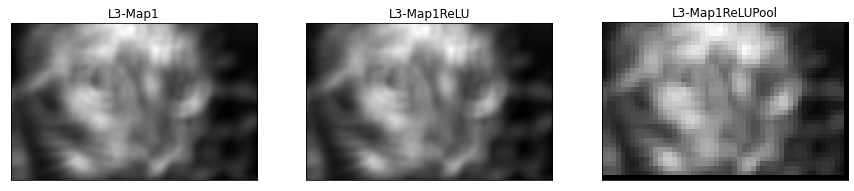

In [15]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

We can see that at progressively higher layers of the network, we get coarser representations of the input. Since the filters at the later layers
are random, they are not very structured, so we get a kind of blurring effect. These visualizations would be more meaningful in model with learned
filters.

### Exercise 2 (15 points)

Modify the three-layer CNN above to use your <code>conv2()</code> function. Check the result, explain what you did, and take note of any differences in the result.

In [16]:
print("conv layer 1...")
l1_feature_maps = conv2(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv2(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv2(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)

conv layer 1...
conv layer 2...
conv layer 3...


The convolution process is faster. The size of image change a bit, it's do not shrink. The result image don't have much different. It's hard to distinguish by eyes.

## CNNs in PyTorch

Now that you've seen layered convolutions in action, at least in feed-forward mode, using structured kernels and random kernels, you can probably imagine how we would backpropagate loss through the ReLU, pooling, and convolutional layers. Don't worry, we won't make you implement it. Let's use the compute graph and gradient calculation features of PyTorch to do the work for us.

We'll next do a more complete CNN example using PyTorch. We'll use the MNIST digits dataset again. The example
is based on [Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

As we learned last week, PyTorch has a few useful modules for us:
1. cuda: GPU-based tensor computations
2. nn: Neural network layer implementations and backpropagation via autograd
3. torchvision: datasets, models, and image transformations for computer vision problems.

The TorchVision module is a separate module that builds on PyTorch and provides datasets
and operations useful for computer vision problems::
1. datasets: TorchVision datasets are subclasses of `torch.utils.data.Dataset`. Some of the most commonly
   used torchvision datasets available are MNIST, CIFAR, and COCO. In this example we will see how to load
   the MNIST dataset using a custom subclass of the higher-level dataset class.
2. transforms: Transforms are used for image transformations. These transformations are useful for preparing
   images for input to our CNN and for so-called data augmentation, in which we perform randomized purturbations
   of input images prior to each training iteration, giving us more variety in the training data. The
   MNIST dataset from torchvision is in the PIL (Python Image Library) image format. To convert MNIST
   images to tensors, we will use `transforms.ToTensor()`.

In [17]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import os


# Set proxy in case it's not already set in our environment before loading torchvision

os.environ['https_proxy'] = 'http://192.41.170.23:3128'
os.environ['http_proxy'] = 'http://192.41.170.23:3128'

import torchvision

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

### Load the MNIST data

First, let's load the data and apply a transfromation of the input elements (pixel intensities) assuming a specific mean and standard deviation over the entire training dataset. Note that PIL automatically normalizes the incoming pixel data, which are integers between 0 and 255, to the floating point range $[0..1]$. For this dataset, we'll use a mean of 0 and a standard deviation of 1, which together imply *no* normalization. We could change `mean` and `stddev` to apply a normalizing transformation.

In [18]:

# Mean and standard deviation to use for normalization. For now, no transformation.

mean = 0.0
stddev = 1.0

# Transform to apply to input images

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([mean], [stddev])])

# Datasets

mnist_train = datasets.MNIST('./data', train=True, download=False, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=False, transform=transform)

The elements of a torch `Dataset` can be accessed with array operations. The dataset has one array element for
each input example. For supervised learning problems, each array element is usually a pair consisting of
an input pattern and an output label (classification) or target value (regression). Let's grab one of the
input images in the dataset. Note that a PyTorch tensor normally makes the feature map or image color channel the
*first* dimension of the tensor, whereas it's usually the *last* dimension in an image.

Input image 12 shape: (1, 28, 28)


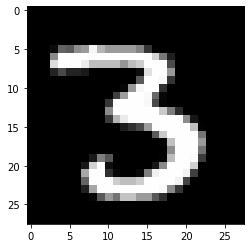

In [19]:
img = mnist_train[12][0].numpy()
print('Input image 12 shape:', img.shape)
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

Since we used a mean of 0 and standard deviation of 1 in our normalizing transform, the image intensities still
vary from 0 to 1:

In [20]:
print('Min pixel intensity:', img.min(), 'max pixel intensity:', img.max())

Min pixel intensity: 0.0 max pixel intensity: 1.0


Let's see how to read one the labels, and also create a `DataLoader` for the dataset. A `DataLoader`
goes through a `Dataset`, optionally shuffling the examples in the set, then loads examples in batches.
The user of a loader applies an iterator to it to grab the batches one by one until the end of the dataset is reached.

In [21]:
label = mnist_train[12][1]
print('Label of image above:', label)

# Reduce batch size if you get out-of-memory errors!

batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

Label of image above: 3


### Define the NN model

Now, let's use two convolutional layers followed by two fully connected layers. The input size of each image is (28,28,1). We will use a stride of 1 and padding of size 0 (valid convolution results only, which will shrink our
input tensor).

For the first convolutional layer, let's apply 20 filters of size $5\times 5$.
The output tensor size formula is $$\text{output size} = \frac{W - F + 2P}{S} + 1,$$
where $W$ is the input size, $F$ is the filter size, $P$ is the padding size, and $S$ is the stride.

In our case, we get $\frac{(28,28,1) - (5,5,1) + (2*0)}{1} + 1$ for each filter, so for 10 filters we get
an output tensor size of (24,24,10).

The ReLU activation function is applied to the output of the first convolutional layer.

For the second convolutional layer, we apply 20 filters of size (5,5), giving us output of size of (20,20,20). Maxpooling with a size of 2 is applied to the output of the second convolutional layer, thereby giving us an output size of of (10,10,20). The ReLU activation function is applied to the output of the maxpooling layer.

Next we have two fully connected layers. The input of the first fully connected layer is flattened output of $10*10*20 = 2000$, with 50 nodes. The second layer is the output layer and has 10 nodes.

In [22]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)      # 24 x 24 x 10  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)     # 20 x 20 x 20  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 20  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 2000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

Now let's create an instance of the neural network model, move it to the GPU, and set up our loss function
and optimizer.

In [23]:
# The model
net = CNN_Model()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

Now let's perform 20 epochs of training. <br>

In [24]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct.item() / float(len(mnist_train_loader.dataset))))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar.item() / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 1.7574, Tr Acc: 47.7700, Val Loss: 0.7054, Val Acc: 77.8400
Epoch 2/20, Tr Loss: 0.5025, Tr Acc: 85.5500, Val Loss: 0.3141, Val Acc: 90.6600
Epoch 3/20, Tr Loss: 0.2927, Tr Acc: 91.3283, Val Loss: 0.2341, Val Acc: 93.0200
Epoch 4/20, Tr Loss: 0.2244, Tr Acc: 93.2917, Val Loss: 0.1894, Val Acc: 94.1200
Epoch 5/20, Tr Loss: 0.1808, Tr Acc: 94.5917, Val Loss: 0.1491, Val Acc: 95.6800
Epoch 6/20, Tr Loss: 0.1492, Tr Acc: 95.5417, Val Loss: 0.1280, Val Acc: 95.9800
Epoch 7/20, Tr Loss: 0.1231, Tr Acc: 96.3467, Val Loss: 0.1046, Val Acc: 96.9100
Epoch 8/20, Tr Loss: 0.1078, Tr Acc: 96.8217, Val Loss: 0.0911, Val Acc: 97.2000
Epoch 9/20, Tr Loss: 0.0966, Tr Acc: 97.1000, Val Loss: 0.0866, Val Acc: 97.4600
Epoch 10/20, Tr Loss: 0.0880, Tr Acc: 97.3600, Val Loss: 0.0808, Val Acc: 97.6100
Epoch 11/20, Tr Loss: 0.0796, Tr Acc: 97.6417, Val Loss: 0.0753, Val Acc: 97.7100
Epoch 12/20, Tr Loss: 0.0744, Tr Acc: 97.7967, Val Loss: 0.0731, Val Acc: 97.7800
Epoch 13/20, Tr Loss: 0.0

We can see that the model is still learning something. We might want to train another 10 epochs or so to see if validation accuracy increases further. For now, though, we'll just save the model.

In [25]:
# save the model
torch.save(net.state_dict(), "./3.model.pth")

Next, let's visualize the loss and accuracy.

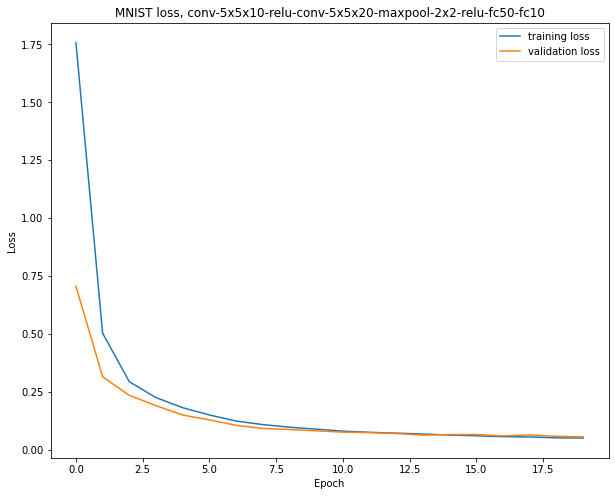

In [26]:
# Plot loss curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.title('MNIST loss, conv-5x5x10-relu-conv-5x5x20-maxpool-2x2-relu-fc50-fc10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

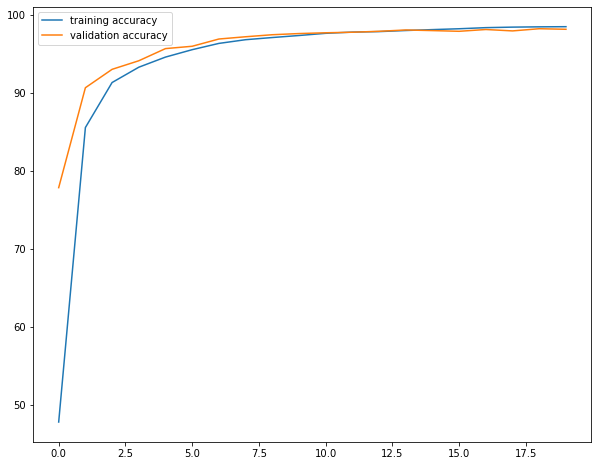

In [27]:
# Plot accuracy curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

What can you conclude from the loss and accuracy curves?
1. We are not overfitting (at least not yet)
2. We should continue training, as validation loss is still improving
3. Validation accuracy is much higher than last week's fully connected models

Now let's test on a single image.

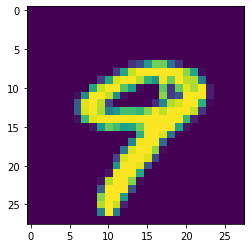

In [28]:
image_index = 9
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]
plt.imshow(img[0,0])
net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

In [29]:
output

tensor([[ -7.2071, -12.3448,  -7.2382,   0.9018,   2.5579,  -1.3543, -15.0231,
           5.6824,   3.8223,  12.3311]], grad_fn=<AddmmBackward0>)

In [30]:
_, predicted = torch.max(output.data, 1)
print("Predicted label:", predicted[0].item())
print("Actual label:", label)

Predicted label: 9
Actual label: 9


### Take-home exercise (70 points)

Apply the tech you've learned up till now to take Kaggle's 2013 [Dogs vs. Cats Challenge](https://www.kaggle.com/c/dogs-vs-cats). Download the training and test datasets and try to build the best PyTorch CNN you can for this dataset. Describe your efforts and the results in a brief lab report.

In [1]:
from skimage.io import imread_collection
from skimage.transform import resize
from skimage.color import rgb2gray
import sys

import torch
import torch.cuda as cuda
import torch.nn as nn
import os
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

# Set proxy in case it's not already set in our environment before loading torchvision

os.environ['https_proxy'] = 'http://192.41.170.23:3128'
os.environ['http_proxy'] = 'http://192.41.170.23:3128'

import torchvision

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

In [2]:
cuda.is_available()

True

/home/Datasets/cats-and-dogs Cat and dog data path


In [33]:
data_dir = '../../dataset'

cat_im_collection = imread_collection(data_dir + '/train/cat.*.jpg')
dog_im_collection = imread_collection(data_dir + '/train/dog.*.jpg')

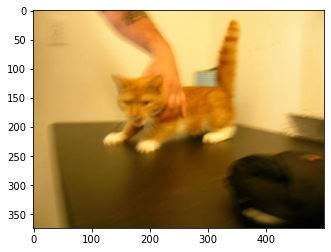

In [34]:
plt.imshow(cat_im_collection[0])

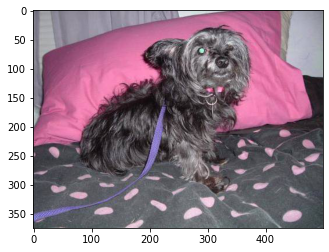

In [35]:
plt.imshow(dog_im_collection[0])

In [6]:
n_dog = len(dog_im_collection)
n_cat = len(cat_im_collection)
n_dog_cat = n_dog + n_cat
dataset = np.zeros((n_dog_cat, 1, 128, 128), dtype='float32')

for i in range(n_cat):
    image = rgb2gray(resize(cat_im_collection[i], (128, 128), anti_aliasing=False))
    dataset[i,0,:,:] = image
    sys.stdout.write('\rimage [{}/{}]'.format(i, n_dog_cat))

for i in range(n_cat, n_dog_cat):
    image = rgb2gray(resize(dog_im_collection[i-n_cat], (128, 128), anti_aliasing=False))
    dataset[i,0,:,:] = image
    sys.stdout.write('\rimage [{}/{}]'.format(i, n_dog_cat))

image [24999/25000]

In [7]:
label_cat = 0
label_dog = 1
label = np.zeros((n_dog_cat), dtype='float32')
label[n_cat:n_dog_cat] = label_dog

label_torch = torch.from_numpy(label)
label_torch = label_torch.type(torch.LongTensor)

In [8]:
X = []
arr = np.arange(n_dog_cat)
np.random.shuffle(arr)
validation_ratio = 0.3

for i in range(n_dog_cat):
    X.append((torch.from_numpy(dataset[arr[i]]), label_torch[arr[i]]))

train_val_split_idx = int(n_dog_cat * 0.3)
X_val = X[0:train_val_split_idx]
X_train = X[train_val_split_idx:]

In [9]:
batch_size = 1000
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=True, num_workers=1)

In [10]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, padding=2)      # 128 x 128 x 5  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=2)     # 128 x 128 x 10  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                  # 64 x 64 x 10  (after pooling)
        self.relu2 = nn.ReLU()                           # Same as above 

        self.conv3 = nn.Conv2d(10, 12, kernel_size=5, padding=2)     # 64 x 64 x 12  (after 2nd convolution)
        self.conv3_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool3 = nn.MaxPool2d(2)                  # 32 x 32 x 12  (after pooling)
        self.relu3 = nn.ReLU()                           # Same as above 

        self.conv4 = nn.Conv2d(10, 15, kernel_size=5, padding=2)     # 32 x 32 x 15  (after 2nd convolution)
        self.conv4_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool4 = nn.MaxPool2d(2)                  # 16 x 16 x 15  (after pooling)
        self.relu4 = nn.ReLU()                           # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(61440, 100)
        self.fc_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.relu2(x)

        # Convolution Layer 4
        x = self.conv4(x)               
        x = self.maxpool4(x)
        x = self.relu4(x)
        
        x = x.view(-1, 61440)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc_drop(x)

        # Fully connected layer 2
        x = self.fc2(x)
        return x

In [12]:
net = CNN_Model()

if cuda.is_available():
    print('cuda')
    torch.cuda.empty_cache()
    net = net.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

In [13]:
num_epochs = 10

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass

        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct.item() / float(len(train_loader.dataset))))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(val_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar.item() / len(val_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])
torch.Size([1000, 15, 64, 64])


KeyboardInterrupt: 

This is a result of training. I use puffer for training process using the same model.
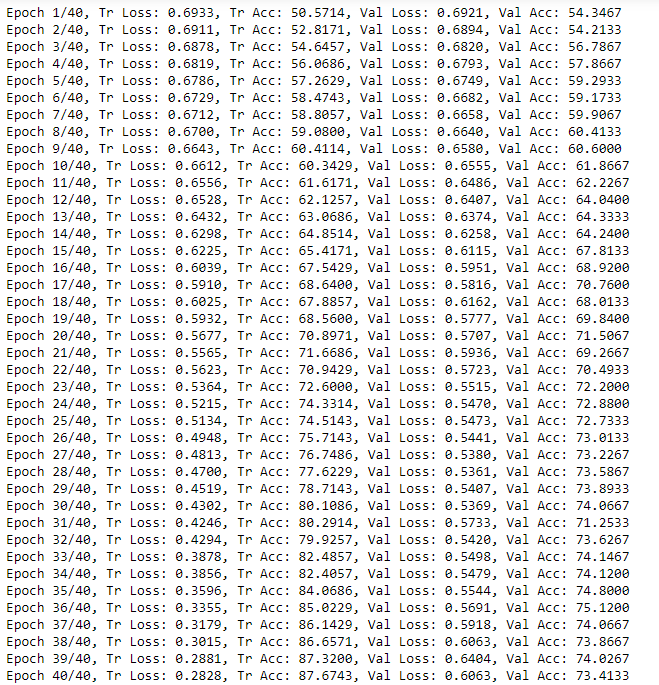
In this test, I have to load all the image, transform to gray scale and resize all the image to equal size. After I have all the image, I have calculate all the layer node size for convultion for each layer and try to implement it. For the first try I get only 50% accuracy. So I use bigger image size for more information and add more convolution network, the training process is very slow. Then I adjust it again and get the final model with accuracy about 75% for validation set.